In [1]:
pip install tensorflow==2.0.0

     |████████████████████████████████| 86.3MB 49kB/s 
     |████████████████████████████████| 450kB 68.4MB/s 
     |████████████████████████████████| 3.8MB 62.5MB/s 
ERROR: tensorflow-federated 0.12.0 has requirement tensorflow~=2.1.0, but you'll have tensorflow 2.0.0 which is incompatible.
ERROR: tensorflow-federated 0.12.0 has requirement tensorflow-addons~=0.7.0, but you'll have tensorflow-addons 0.8.3 which is incompatible.
  Found existing installation: tensorflow-estimator 1.15.1
    Uninstalling tensorflow-estimator-1.15.1:
      Successfully uninstalled tensorflow-estimator-1.15.1
  Found existing installation: tensorboard 1.15.0
    Uninstalling tensorboard-1.15.0:
      Successfully uninstalled tensorboard-1.15.0
  Found existing installation: tensorflow 1.15.0
    Uninstalling tensorflow-1.15.0:
      Successfully uninstalled tensorflow-1.15.0


이번장에 사용할 네트워크는 RED-Net이라는 네트워크이다. RED-Net은 Residual Encoder Decoder Network의 약자로 인코더와 디코더는 오토인코더에서 이미 봤고 Residual 은 ResNet 등에서 사용하는 건너뛴 연결이다. 이는 다수의 레이어가 중첩되는 구조에서는 앞쪽의 정보를 잃어버리지 않기 위해 뒤쪽에 정보를 그래로 전달해줄 때 건너뛴 연결이 사용된다.

REDNet-30 은 15개의 컨볼루션 레이어와 15개의 디컨볼루션 레이어로 구성된다. 입출력 그리고 그 사이에 존재하는 컨볼루션 레이어와 디컨볼루션 레이어를 거치는 데이터의 크기는 모두 동일하다. 

In [2]:
import tensorflow as tf


# 9.18 BSD500 데이터세트 불러오기
tf.keras.utils.get_file('/content/bsd_images.zip', 'http://bit.ly/35pHZlC', extract=True)

!unzip /content/bsd_images.zip

37527552/37520292 [==============================] - 0s 0us/step
Archive:  /content/bsd_images.zip
   creating: images/
   creating: images/test/
  inflating: images/test/100007.jpg  
  inflating: images/test/100039.jpg  
  inflating: images/test/100099.jpg  
  inflating: images/test/10081.jpg   
  inflating: images/test/101027.jpg  
  inflating: images/test/101084.jpg  
  inflating: images/test/102062.jpg  
  inflating: images/test/103006.jpg  
  inflating: images/test/103029.jpg  
  inflating: images/test/103078.jpg  
  inflating: images/test/104010.jpg  
  inflating: images/test/104055.jpg  
  inflating: images/test/105027.jpg  
  inflating: images/test/106005.jpg  
  inflating: images/test/106047.jpg  
  inflating: images/test/107014.jpg  
  inflating: images/test/107045.jpg  
  inflating: images/test/107072.jpg  
  inflating: images/test/108004.jpg  
  inflating: images/test/108036.jpg  
  inflating: images/test/108069.jpg  
  inflating: images/test/109055.jpg  
  inflating: image

In [3]:
# 이미지 경로 저장 및 확인
import pathlib

image_root = pathlib.Path('/content/images')

all_images_paths = list(image_root.glob('*/*'))
print(all_images_paths[:10])

[PosixPath('/content/images/val/182053.jpg'), PosixPath('/content/images/val/33039.jpg'), PosixPath('/content/images/val/41033.jpg'), PosixPath('/content/images/val/14037.jpg'), PosixPath('/content/images/val/148089.jpg'), PosixPath('/content/images/val/285079.jpg'), PosixPath('/content/images/val/130026.jpg'), PosixPath('/content/images/val/175032.jpg'), PosixPath('/content/images/val/3096.jpg'), PosixPath('/content/images/val/304074.jpg')]


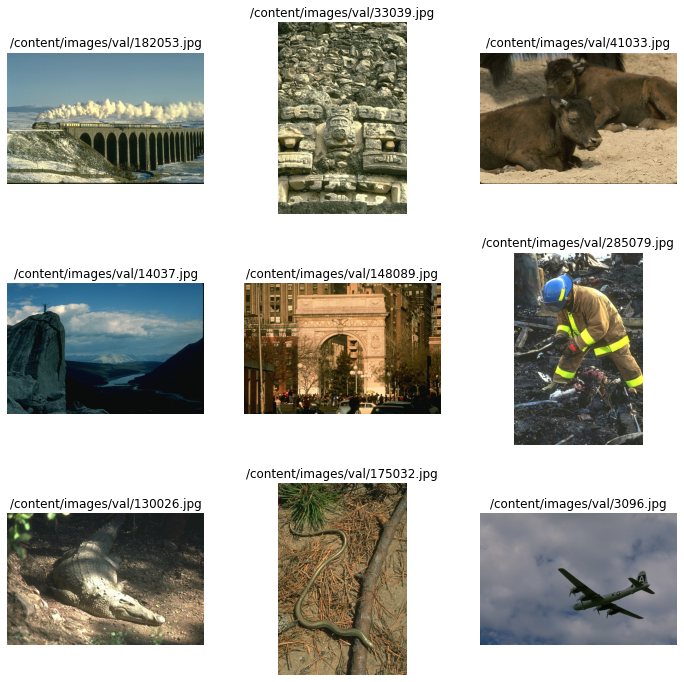

In [4]:
# 이미지 확인
import PIL.Image as Image
import matplotlib.pyplot as plt

plt.figure(figsize=(12,12))
for c in range(9):
    plt.subplot(3, 3, c+1)
    plt.imshow(plt.imread(all_images_paths[c]))
    plt.title(all_images_paths[c])
    plt.axis('off')

plt.show()

BSD500은 200장의 훈련 데이터, 100장의 검증 데이터, 200장의 테스트 데이터로 구성돼 있다. 각 데이터셋 집합을 처리하기 위한 tf.data.Dataset 를 각 데이터셋마다 만들어보자. 이를 위해 해야할 첫번째 행동은 이미지의 경로를 분리해서 저장하는 것이다.

In [0]:
# 이미지 경로 분리 지정
train_path, valid_path, test_path = [],[],[]

for image_path in all_images_paths:
    if str(image_path).split('.')[-1] != 'jpg':
        continue
    if str(image_path).split('/')[-2] == 'train':
        train_path.append(str(image_path))
    elif str(image_path).split('/')[-2] == 'val':
        valid_path.append(str(image_path))
    else:
        test_path.append(str(image_path))

tf.data.Dataset을 정의하기 전 여기서 사용할 함수를 만든다. 현재 가지고 있는 이미지는 고해상도이기 때문에 이미지의 해상도를 일부러 낮추고 원본과 함께 반환하는 함수를 만들겠다. 또 학습 효율을 높이기 위해 이미지를 받아온 다음 다음 이미지에서 가로 x 세로 50픽셀의 작은 조각을 잘라서 학습에 사용해보자.


- 저해상도의 이미지는 입력으로 사용
- 고해상도의 이미지는 출력에 사용


In [0]:
# 원본 이미지에서 조각을 추출하고 입력, 출력 데이터를 반환하는 함수 정의
# : 원본 이미지에서 고해상도와 저해상도의 조각을 만드는 함수
def get_hr_and_lr(image_path):
    img = tf.io.read_file(image_path) # jpeg 이미지 불러오기
    img = tf.image.decode_jpeg(img, channels=3) # 프로그램이 이해할 수 있는 데이터 형태로 변환
    img = tf.image.convert_image_dtype(img, tf.float32) # float32 데이터 타입으로 변환

    hr = tf.image.random_crop(img, [50, 50, 3]) # 가로, 세로 50픽셀의 이미지를 얻기 위한 함수
    lr = tf.image.resize(hr, [25, 25]) # 크기 축소
    lr = tf.image.resize(lr, [50, 50]) # 크기 다시 확대
    return lr, hr

학습 과정에서 사용할 훈련 데이터와 검증 데이터를 사용하는 dataset을 각각 정의한다.

In [0]:
# 9.23 train, valid Dataset 정의
train_dataset = tf.data.Dataset.list_files(train_path) # 파일 경로리스트가 있다면 list_files()의 인수로 파일경로 넘김
train_dataset = train_dataset.map(get_hr_and_lr) # 새로운 dataset 정의
# get_hr_and_lr()함수와 map()함수 적용
# 이렇게 연결시 dataset는 먼저 train_path리스트의 이미지를 불러온 다음에 저해상도와 고해상도 조각인 lr, hr 반환

train_dataset = train_dataset.repeat() # 데이터 반복 사용 위함
train_dataset = train_dataset.batch(16)

valid_dataset = tf.data.Dataset.list_files(valid_path)
valid_dataset = valid_dataset.map(get_hr_and_lr)
valid_dataset = valid_dataset.repeat()
valid_dataset = valid_dataset.batch(1)

REDNet 정의 : 컨볼루션 15개를 쌓은 후 디컨볼루션 레이어를 15개 쌓은 단순한 구조
- 컨볼루션 레이어와 디컨볼루션 레이어를 각 2칸씩 건너뛴다.
- 연결된 합연산이 relu활성화함수를 거쳐 다음 디컨볼루션으로 연결



REDnet-30은 구조가 직선형이 아니기 때문에 Sequential()이 아닌 함수형 API를 사용해서 네트워크 정의해야 한다.

In [0]:
# tf.keras의 함수형 API를 사용한 REDNet 네트워크 정의

def REDNet(num_layers): # num_layers : conv + deconv layers
    conv_layers = []
    deconv_layers = []
    residual_layers = []

    # input layer 정의
    inputs = tf.keras.layers.Input(shape=(None, None, 3)) # 어떤 크기의 이미지라도 입력으로 받도록
    # 첫번째 conv 레이어
    conv_layers.append(tf.keras.layers.Conv2D(3, kernel_size=3, padding='same', activation='relu'))

    for i in range(num_layers-1):  # 첫번째 conv 레이어와 마지막 deconv 레이어 제외 for문 안에서 나머지 레이어들 정의
        conv_layers.append(tf.keras.layers.Conv2D(64, kernel_size=3, padding='same', activation='relu'))
        deconv_layers.append(tf.keras.layers.Conv2DTranspose(64, kernel_size=3, padding='same', activation='relu'))

    # 마지막 deconv 레이어
    deconv_layers.append(tf.keras.layers.Conv2DTranspose(3, kernel_size=3, padding='same'))

    # 인코더 시작
    x = conv_layers[0](inputs) # x는 입력 레이어에 첫번째 컨볼루션 레이어 적용한 결과

    for i in range(num_layers-1):
        x = conv_layers[i+1](x)
        if i % 2 == 0:  # 짝수번째 컨볼루션 레이어 통과시  x를 residaul_layer 리스트에 저장
            residual_layers.append(x)
            # residual_layers에 x를 저장한 다음 다음 스텝에서 x는 다시 conv_layers를 통과해서 새로운 값이 된다. 

    # 디코더 시작
    for i in range(num_layers-1):
        if i % 2 == 1: # 홀수번째 deconv_layers 통과시 residual_layers에 저장돼있던 값을 
                       # residual_layers.pop()으로 뒤에서부터 하나씩 가져온다.

            x = tf.keras.layers.Add()([x, residual_layers.pop()]) # 합연산
            x = tf.keras.layers.Activation('relu')(x) # 합연산과 relu 통과 후 deconv_layers에 연결
        x = deconv_layers[i](x) 
        # 홀수면 합+relu 통과 후 deconv_layers에 연결
        # 짝수면 deconv_layers에 연결

    x = deconv_layers[-1](x)  # 컬러 이미지를 복원하는 3채널의 deconv_layer를 x에 적용하면 연산 종료

    # 모델 정의
    model = tf.keras.Model(inputs=inputs, outputs=x)
    return model

고해상도 이미지가 잘 복원됐는지 알기 위해서 특별한 측정값을 컴파일에 추가해서 테스트할 수 있다. 이 측정값은 PSNR(Peak Signal to Noise Ratio), 즉, 신호 대 잡음비 이다.
이는 원본 이미지와 재구성된 이미지의 PSNR을 계산하면 이미지의 품질이 얼마나 좋은지 측정할 수 있다.

동일한 2개의 이미지를 PSNR로 계산하면 무한대의 값이 나오고 보통 30이상이면 좋은 값이다.

- MSE(Mean Square Error) : 평균 제곱 오차
PSNR 식에서 평균 제곱 오차가 로그의 분모에 있기 때문에 평균 제곱 오차가 낮을수록 큰 값을 가진다.

In [0]:
# PSNR 정의
def psnr_metric(y_true, y_pred): 
    return tf.image.psnr(y_true, y_pred, max_val=1.0)
    # y_true : 정답값, y_predL 예측값

In [0]:
# REDNet-30 네트워크 초기화 및 컴파일
model = REDNet(15)
model.compile(optimizer=tf.optimizers.Adam(0.0001), loss='mse', metrics=[psnr_metric])
# metrics : 학습이 잘 되는지 알아보기 위한 측정값을 지정한다.
# 
              

In [11]:
# REDNet-30 네트워크 학습
history = model.fit_generator(train_dataset, epochs=100, steps_per_epoch=len(train_path)//16, validation_data=valid_dataset, validation_steps=len(valid_path), verbose=2)

Epoch 1/100
12/12 - 89s - loss: 0.2259 - psnr_metric: 7.9922 - val_loss: 0.1188 - val_psnr_metric: 11.4542
Epoch 2/100
12/12 - 84s - loss: 0.0582 - psnr_metric: 13.5031 - val_loss: 0.0419 - val_psnr_metric: 15.1732
Epoch 3/100
12/12 - 82s - loss: 0.0324 - psnr_metric: 15.8755 - val_loss: 0.0305 - val_psnr_metric: 15.9637
Epoch 4/100
12/12 - 81s - loss: 0.0306 - psnr_metric: 16.1320 - val_loss: 0.0259 - val_psnr_metric: 16.7760
Epoch 5/100
12/12 - 79s - loss: 0.0273 - psnr_metric: 16.6947 - val_loss: 0.0218 - val_psnr_metric: 17.5207
Epoch 6/100
12/12 - 77s - loss: 0.0251 - psnr_metric: 17.1278 - val_loss: 0.0202 - val_psnr_metric: 17.8880
Epoch 7/100
12/12 - 77s - loss: 0.0232 - psnr_metric: 17.7490 - val_loss: 0.0207 - val_psnr_metric: 18.1243
Epoch 8/100
12/12 - 76s - loss: 0.0214 - psnr_metric: 17.8093 - val_loss: 0.0184 - val_psnr_metric: 18.5550
Epoch 9/100
12/12 - 81s - loss: 0.0215 - psnr_metric: 18.1233 - val_loss: 0.0167 - val_psnr_metric: 18.9966
Epoch 10/100
12/12 - 81s - lo

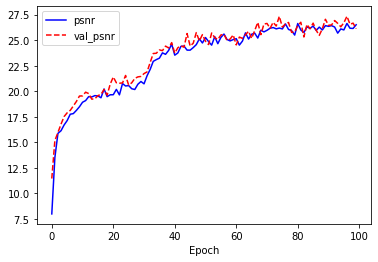

In [12]:
# REDNet-30 네트워크 학습 결과 확인
import matplotlib.pyplot as plt
plt.plot(history.history['psnr_metric'], 'b-', label='psnr')
plt.plot(history.history['val_psnr_metric'], 'r--', label='val_psnr')
plt.xlabel('Epoch')
plt.legend()

plt.show()

훈련 데이터와 검증 데이터의 psnr 모두 학습할수록 증가하는 경향을 보인다.
학습된 네트워크가 실제 이미지를 어떻게 복원하는지 확인해보자.

In [13]:
import numpy as np

# test 이미지에 대한 초해상도
img = tf.io.read_file(test_path[0])
img = tf.image.decode_jpeg(img, channels=3)
hr = tf.image.convert_image_dtype(img, tf.float32)

lr = tf.image.resize(hr, [hr.shape[0]//2, hr.shape[1]//2])
lr = tf.image.resize(lr, [hr.shape[0], hr.shape[1]])
predict_hr = model.predict(np.expand_dims(lr, axis=0))

print(tf.image.psnr(np.squeeze(predict_hr, axis=0), hr, max_val=1.0))
print(tf.image.psnr(lr, hr, max_val=1.0))

tf.Tensor(25.30417, shape=(), dtype=float32)
tf.Tensor(28.347086, shape=(), dtype=float32)


테스트 데이터 중 첫번째 이미지를 불러와서 저해상도 버전을 만든 다음 REDNet-30 네트워크에 통과시켜서 복원 이미지를 얻어냈다. 결과에서 PSNR 점수는 복원 이미지가 저해상도 이미지보다 아줒 살짝 높은 것으로 나온다. 

이미지로 확인을 해보자.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


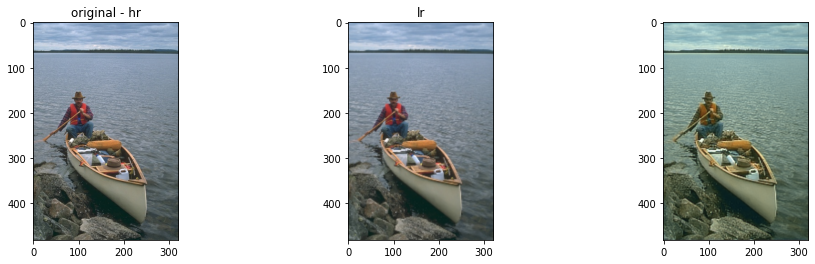

In [14]:
# test 이미지에 대한 초해상도 결과 확인
plt.figure(figsize=(16,4))

# 원본 이미지
plt.subplot(1, 3, 1)
plt.imshow(hr)
plt.title('original - hr')

# 저해상도
plt.subplot(1, 3, 2)
plt.imshow(lr)
plt.title('lr')

# 복원된 이미지
plt.subplot(1, 3, 3)
plt.imshow(np.squeeze(predict_hr, axis=0))

plt.show()

이 작업들의 성능을 비교하기 위한 벤치마크 중 유명한 Set5라는 데이터 셋을 이용해보자.

In [15]:
# Set5 나비 이미지 테스트
image_path = tf.keras.utils.get_file('butterfly.png','http://bit.ly/2oAOxgH')
img = tf.io.read_file(image_path)
img = tf.image.decode_jpeg(img, channels=3)
hr = tf.image.convert_image_dtype(img, tf.float32)

lr = tf.image.resize(hr, [hr.shape[0]//2, hr.shape[1]//2])
lr = tf.image.resize(lr, [hr.shape[0], hr.shape[1]])
predict_hr = model.predict(np.expand_dims(lr, axis=0))

print(tf.image.psnr(np.squeeze(predict_hr, axis=0), hr, max_val=1.0))
print(tf.image.psnr(lr, hr, max_val=1.0))


131072/127529 [==============================] - 0s 0us/step
tf.Tensor(22.385536, shape=(), dtype=float32)
tf.Tensor(24.783773, shape=(), dtype=float32)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'sr')

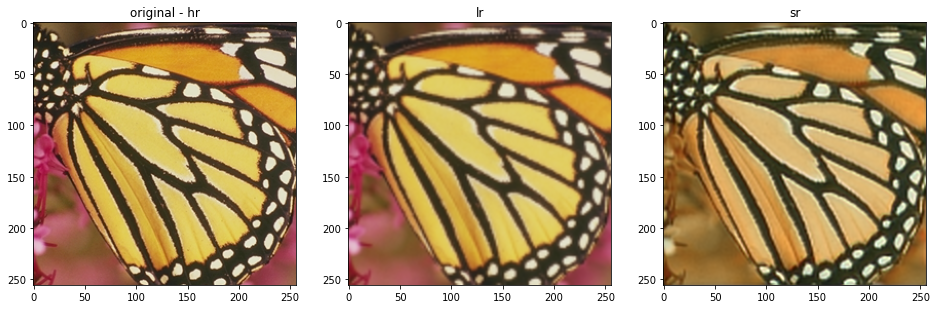

In [16]:
# 시각화
plt.figure(figsize=(16,6))
plt.subplot(1, 3, 1)
plt.imshow(hr)
plt.title('original - hr')

plt.subplot(1, 3, 2)
plt.imshow(lr)
plt.title('lr')

plt.subplot(1, 3, 3)
plt.imshow(np.squeeze(predict_hr, axis=0))
plt.title('sr')


좀더 어려운 과제로 확대 비율을 늘려볼 수 있다. 현재는 2배로 했는데 4배로 늘려보는 것을 시도해보자.

어려운 과제이기 때문에 네트워크의 성능을 높이기 위해 이미지 보강이 필요하다. 

In [0]:
# 확대 비율을 2배에서 4배로 수정, 이미지 보강
import random
def get_hr_and_lr_flip_s4(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)

    hr = tf.image.random_crop(img, [50, 50, 3])
    lr = tf.image.resize(hr, [12, 12])
    lr = tf.image.resize(lr, [50, 50])

    if random.random() < 0.25:
        hr = tf.image.flip_left_right(hr)
        lr = tf.image.flip_left_right(lr)

    if random.random() < 0.25:
        hr = tf.image.flip_up_down(hr)
        lr = tf.image.flip_up_down(lr)

    return lr, hr

앞부분은 축소, 확대 비율을 4배로 바꾸는 부분을 제외하면 get_hr_and_lr() 함수와 같다. 뒤쪽에 25%의 확률로 좌우반전, 상하 반전을 시켜준다.

결과적으로 훈련 데이터가 4배로 늘어나는 효과를 가질 것이다.

In [0]:
# REDNet-30 네트워크 학습
train_dataset = tf.data.Dataset.list_files(train_path)
train_dataset = train_dataset.map(get_hr_and_lr_flip_s4)
train_dataset = train_dataset.repeat()
train_dataset = train_dataset.batch(16)

valid_dataset = tf.data.Dataset.list_files(valid_path)
valid_dataset = valid_dataset.map(get_hr_and_lr_flip_s4)
valid_dataset = valid_dataset.repeat()
valid_dataset = valid_dataset.batch(1)

model = REDNet(15)
model.compile(optimizer=tf.optimizers.Adam(0.0001), loss='mse', metrics=[psnr_metric])

In [19]:
history = model.fit_generator(train_dataset, epochs=50, steps_per_epoch=len(train_path)//16,
                              validation_data=valid_dataset, validation_steps=len(valid_path),
                              verbose=2)

Epoch 1/50
12/12 - 83s - loss: 0.2190 - psnr_metric: 8.0689 - val_loss: 0.2166 - val_psnr_metric: 8.3912
Epoch 2/50
12/12 - 86s - loss: 0.1455 - psnr_metric: 10.2306 - val_loss: 0.0875 - val_psnr_metric: 11.2663
Epoch 3/50
12/12 - 86s - loss: 0.0747 - psnr_metric: 12.4066 - val_loss: 0.0604 - val_psnr_metric: 13.4245
Epoch 4/50
12/12 - 87s - loss: 0.0617 - psnr_metric: 13.3100 - val_loss: 0.0667 - val_psnr_metric: 13.1455
Epoch 5/50
12/12 - 84s - loss: 0.0585 - psnr_metric: 13.2618 - val_loss: 0.0648 - val_psnr_metric: 12.9248
Epoch 6/50
12/12 - 82s - loss: 0.0608 - psnr_metric: 13.3242 - val_loss: 0.0552 - val_psnr_metric: 13.5231
Epoch 7/50
12/12 - 82s - loss: 0.0543 - psnr_metric: 13.6913 - val_loss: 0.0610 - val_psnr_metric: 13.4488
Epoch 8/50
12/12 - 82s - loss: 0.0495 - psnr_metric: 13.9450 - val_loss: 0.0529 - val_psnr_metric: 13.8336
Epoch 9/50
12/12 - 82s - loss: 0.0494 - psnr_metric: 14.2318 - val_loss: 0.0532 - val_psnr_metric: 14.1264
Epoch 10/50
12/12 - 82s - loss: 0.0511 

이미지 보강으로 데이터가 4배정도 늘어난 것과 같은 효과가 나기 때문에 원래느 epoch를 4배로 해주어야 하지만 시간 관계상 epoch를 50으로 주었다. 

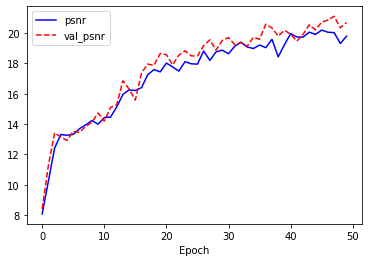

In [20]:
# REDNet-30 네트워크 학습 결과 확인
import matplotlib.pyplot as plt
plt.plot(history.history['psnr_metric'], 'b-', label='psnr')
plt.plot(history.history['val_psnr_metric'], 'r--', label='val_psnr')
plt.xlabel('Epoch')
plt.legend()

plt.show()

tf.Tensor(15.067497, shape=(), dtype=float32)
tf.Tensor(20.217585, shape=(), dtype=float32)


Text(0.5, 1.0, 'sr')

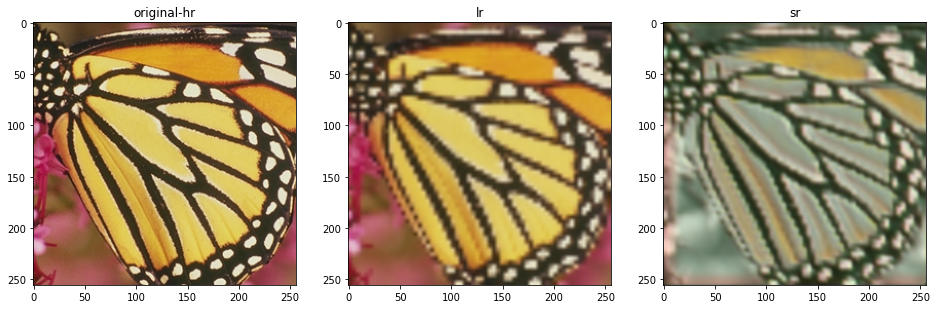

In [22]:
# 4배 축소, 확대한 나비 이미지 테스트 결과
image_path = tf.keras.utils.get_file('butterfly.png', 'http://bit.ly/2oAOxgH')
img = tf.io.read_file(image_path)
img = tf.image.decode_jpeg(img, channels=3)
hr = tf.image.convert_image_dtype(img, tf.float32)

lr = tf.image.resize(hr, [hr.shape[0]//4, hr.shape[1]//4])
lr = tf.image.resize(lr, [hr.shape[0], hr.shape[1]])
predict_hr = model.predict(np.expand_dims(lr, axis=0))

print(tf.image.psnr(np.squeeze(predict_hr, axis=0), hr, max_val=1.0))
print(tf.image.psnr(lr, hr, max_val=1.0))

plt.figure(figsize=(16,6))
plt.subplot(1,3,1)
plt.imshow(hr)
plt.title('original-hr')

plt.subplot(1,3,2)
plt.imshow(lr)
plt.title('lr')

plt.subplot(1,3,3)
plt.imshow(np.squeeze(predict_hr, axis=0))
plt.title('sr')


가운데 저해상도 버전에 뚜렷하게 보이는 픽셀이 복원된 이미지에서 많이 정리되어 자연스러워진것을 확인할 수 있다.

Set5를 구성하는 모든 이미지의 PSNR 점수를 확인해보자.

In [23]:
# Set5 이미지 불러오기
image_path = tf.keras.utils.get_file('/content/Set5.zip', 'http://bit.ly/2MEG4kr')
!unzip Set5.zip

860160/852576 [==============================] - 0s 0us/step
Archive:  Set5.zip
   creating: Set5/
 extracting: Set5/baby.png           
 extracting: Set5/bird.png           
 extracting: Set5/butterfly.png      
 extracting: Set5/head.png           
  inflating: Set5/woman.png          


In [26]:
# Set5 이미지 PSNR 점수 확인
set5_image_root = pathlib.Path('/content/Set5')
set5_image_paths = list(set5_image_root.glob('*.*'))

sr_psnr = []
lr_psnr = []

for image_path in set5_image_paths:
    img = tf.io.read_file(str(image_path))
    img = tf.image.decode_jpeg(img, channels=3)
    hr = tf.image.convert_image_dtype(img, tf.float32)

    lr = tf.image.resize(hr, [hr.shape[0] // 4, hr.shape[1]//4])
    lr = tf.image.resize(lr, [hr.shape[0], hr.shape[1]])
    predict_hr = model.predict(np.expand_dims(lr, axis=0))

    sr_psnr.append(tf.image.psnr(np.squeeze(predict_hr, axis=0), hr, max_val=1.0).numpy())
    lr_psnr.append(tf.image.psnr(lr, hr, max_val=1.0).numpy())

print('sr: ',sr_psnr)
print('sr mean:', np.mean(sr_psnr))
print('------')
print('lr: ', lr_psnr)
print('lr mean:', np.mean(lr_psnr))

sr:  [15.067497, 16.514833, 15.826663, 19.939085, 17.162966]
sr mean: 16.902208
------
lr:  [20.217585, 24.495182, 28.569515, 27.31659, 29.72251]
lr mean: 26.064276
